# Capstone Project - The Battle of Neighborhoods

### Introduction

New York City's demographics show that it is a large and ethnically diverse metropolis. It is the largest city in the United States with a long history of international immigration. New York City was home to nearly 8.5 million people in 2014, accounting for over 40% of the population of New York State and a slightly lower percentage of the New York metropolitan area, home to approximately 23.6 million. Over the last decade the city has been growing faster than the region. The New York region continues to be by far the leading metropolitan gateway for legal immigrants admitted into the United States.

Throughout its history, New York City has been a major point of entry for immigrants; the term "melting pot" was coined to describe densely populated immigrant neighborhoods on the Lower East Side. As many as 800 languages are spoken in New York, making it the most linguistically diverse city in the world. English remains the most widely spoken language, although there are areas in the outer boroughs in which up to 25% of people speak English as an alternate language, and/or have limited or no English language fluency. English is least spoken in neighborhoods such as Flushing, Sunset Park, and Corona.

With it's diverse culture , comes diverse food items. There are many resturants in New york City, each beloning to different categories like Chinese , italian , French etc.

So as part of this project , we will list and visualize all major parts of New York City that has great italian resturants.

### Data 
For this project we need the following data :
<ul>
<li> New York City data that contains list Boroughs, Neighborhoods along with their latitude and longitude.
    <ul>
        <li>Data source : https://cocl.us/new_york_dataset
        <li> Description : This data set contains the required information. And we will use this data set to explore various neighborhoods of new york city.
     </ul>
<li> italian resturants in each neighborhood of new york city.
        <ul>
        <li>Data source : Fousquare API
        <li> Description : By using this api we will get all the venues in each neighborhood. We can filter these venues to get only italian resturants.
     </ul>
<li> GeoSpace data
          <ul>
        <li>Data source : https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm
        <li> Description : By using this geo space data we will get the New york Borough boundaries that will help us visualize choropleth map.
  
</ul>

### Approach
- Collect the new york city data from https://cocl.us/new_york_dataset
- Using FourSquare API we will find all venues for each neighborhood.
- Filter out all venues that are italian Resturants.
- Find rating , tips and like count for each italian Resturants using FourSquare API.
- Using rating for each resturant , we will sort that data.
- Visualize the Ranking of neighborhoods using folium library(python)

### Questions that can be asked using the above mentioned datasets
- What is best location in New York City for italian Cuisine ? 
- Which areas have potential italian Resturant Market ? 
- Which all areas lack italian Resturants ?
- Which is the best place to stay if I prefer italian Cuisine ?

### Analysis

We will import the required libraries for python.

- pandas and numpy for handling data.
- request module for using FourSquare API.
- geopy to get co-ordinates of City of New York.
- folium to visualize the results on a map

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
import geocoder
import os
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')

Libraries imported.


Now we define a function to get the geocodes i.e latitude and longitude of a given location using geopy.

In [2]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

We define a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given  latitude and longitude. Below function will return us the venue id , venue name and category.

In [3]:
CLIENT_ID = "" # your Foursquare ID
CLIENT_SECRET = "" # your Foursquare Secret

def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df
    

Now we will define a function to get venue details like like count , rating , tip counts for a given venue id.
This will be used for ranking.

In [4]:
def get_venue_details(venue_id):
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    print(url)
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


Now we define a funtion to get the new york city data such as Boroughs, Neighborhoods along with their latitude and longitude.

In [5]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

We will call the above funtion to get the new york city data.

In [6]:
# get new york data
new_york_data=get_new_york_data()

In [7]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [8]:
new_york_data.shape

(306, 4)

So there are total of 306 different Neighborhoods in New York

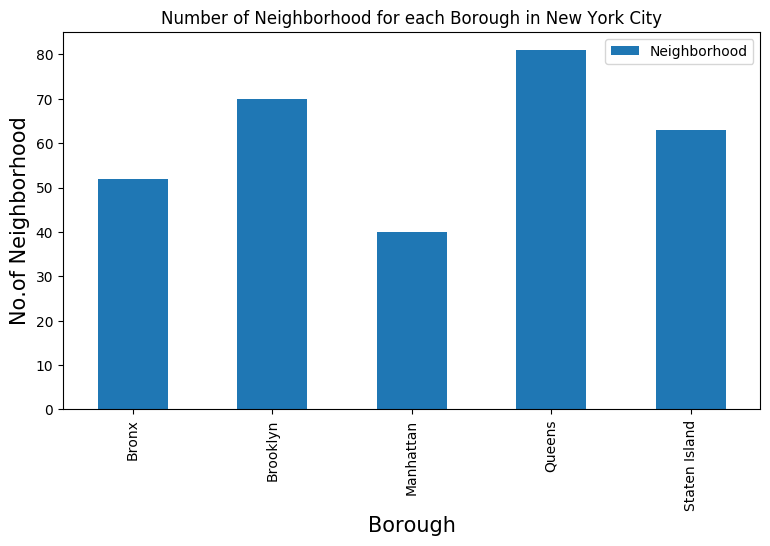

In [9]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We see that Queens has highest number of neighborhoods

Now we will collect italian resturants for each Neighborhood

In [10]:
# prepare neighborhood list that contains italian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
italian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    italian_resturants=venues[venues['Category']=='Italian Restaurant']   
    print('(',count,'/',len(new_york_data),')','italian Resturants in '+Neighborhood+', '+Borough+':'+str(len(italian_resturants)))
    for resturant_detail in italian_resturants.values.tolist():
        id, name , category=resturant_detail
        italian_rest_ny = italian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) italian Resturants in Wakefield, Bronx:0
( 2 / 306 ) italian Resturants in Co-op City, Bronx:0
( 3 / 306 ) italian Resturants in Eastchester, Bronx:0
( 4 / 306 ) italian Resturants in Fieldston, Bronx:0
( 5 / 306 ) italian Resturants in Riverdale, Bronx:1
( 6 / 306 ) italian Resturants in Kingsbridge, Bronx:1
( 7 / 306 ) italian Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) italian Resturants in Woodlawn, Bronx:2
( 9 / 306 ) italian Resturants in Norwood, Bronx:0
( 10 / 306 ) italian Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) italian Resturants in Baychester, Bronx:2
( 12 / 306 ) italian Resturants in Pelham Parkway, Bronx:3
( 13 / 306 ) italian Resturants in City Island, Bronx:3
( 14 / 306 ) italian Resturants in Bedford Park, Bronx:0
( 15 / 306 ) italian Resturants in University Heights, Bronx:0
( 16 / 306 ) italian Resturants in Morris Heights, Bronx:0
( 17 / 306 ) italian Resturants in Fordham, Bronx:9
( 18 / 306 ) italian Resturants in East Tremont, Bronx:

Now that we have got all the italian resturants in new york city , we will analyze it

In [11]:
italian_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Riverdale,55aaee4d498e3cbb70e625d6,Bella Notte Pizzeria
1,Bronx,Kingsbridge,55aaee4d498e3cbb70e625d6,Bella Notte Pizzeria
2,Bronx,Woodlawn,511edb6de4b0d58346fd272d,Patrizia's Of Woodlawn
3,Bronx,Woodlawn,4d3cb3026b3d236a066a6364,Rivers Edge
4,Bronx,Baychester,4c9518076b35a143d5dc21dc,Fratelli's


In [12]:
italian_rest_ny.shape

(537, 4)

We got 544 italian Resturants across New York City

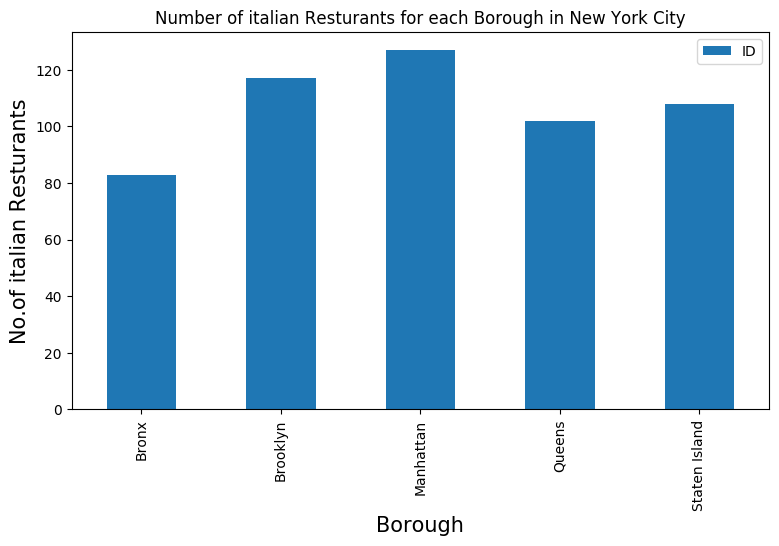

In [13]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of italian Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of italian Resturants', fontsize=15)
#giving a bar plot
italian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We see that manhattan has the largest number of italian resturants

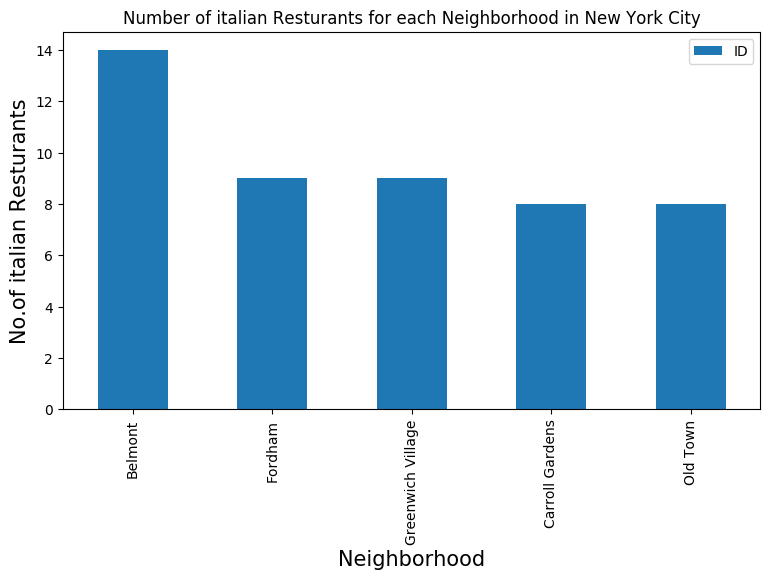

In [14]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of italian Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of italian Resturants', fontsize=15)
#giving a bar plot
italian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [15]:
italian_rest_ny[italian_rest_ny['Neighborhood']=='Belmont']

,Borough,Neighborhood,ID,Name
42,Bronx,Belmont,4acf80aef964a52025d420e3,Tino's Delicatessen
43,Bronx,Belmont,4bb6470cef159c7465b275f7,Calabria Pork Store
44,Bronx,Belmont,4af0fa29f964a52060e021e3,Antonio's Trattoria
45,Bronx,Belmont,59050f51b23dfa5f6649e678,Arthur Avenue Fiasco
46,Bronx,Belmont,4aa425bef964a5208e4520e3,Dominick's Restaurant
47,Bronx,Belmont,4b5514c4f964a5207cda27e3,Enzo's
48,Bronx,Belmont,4a8e261cf964a5201c1220e3,Roberto's
49,Bronx,Belmont,4af71916f964a520cf0522e3,Michaelangelo's Coal Fired Brick Oven Pizza Re...
50,Bronx,Belmont,4aa193d5f964a520124120e3,Mario's Restaurant & Catering
51,Bronx,Belmont,4c79d294278eb713f6a05580,Cafe al Mercato


So Belmont in manhattan has the highest number of italian Resturants with a total count of 14.

Now we will get the ranking of each resturant for further analysis.

In [16]:
# prepare neighborhood list that contains italian resturants
# Limit list because foursquare API limitation on free account
italian_rest_ny = italian_rest_ny.sample(250, random_state=1)
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
italian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in italian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(italian_rest_ny),')','processed')
    italian_rest_stats_ny = italian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

https://api.foursquare.com/v2/venues/4b634812f964a520936f2ae3?&client_id=RXLXWFOOF5VDJCVLIJHVV5FSDA0FVNF2HYQ5XQMNIPLSW5HZ&client_secret=NNE2L3F3J5HH4NTA5YZCCKLY242PMR4X32H4F0Y54FVSD44Z&v=20180605
                         ID         Name  Likes  Rating  Tips
0  4b634812f964a520936f2ae3  Vito's Deli      6     6.7     5
( 1 / 250 ) processed
https://api.foursquare.com/v2/venues/4b9a599af964a5201aae35e3?&client_id=RXLXWFOOF5VDJCVLIJHVV5FSDA0FVNF2HYQ5XQMNIPLSW5HZ&client_secret=NNE2L3F3J5HH4NTA5YZCCKLY242PMR4X32H4F0Y54FVSD44Z&v=20180605
                         ID        Name  Likes  Rating  Tips
0  4b9a599af964a5201aae35e3  Cucina Mia      5     7.0     3
( 2 / 250 ) processed
https://api.foursquare.com/v2/venues/56d8e01d498ef1500ae7fbfe?&client_id=RXLXWFOOF5VDJCVLIJHVV5FSDA0FVNF2HYQ5XQMNIPLSW5HZ&client_secret=NNE2L3F3J5HH4NTA5YZCCKLY242PMR4X32H4F0Y54FVSD44Z&v=20180605
                         ID  Name  Likes  Rating  Tips
0  56d8e01d498ef1500ae7fbfe  Fumo    100     9.0    22
( 3 / 250 ) 

In [17]:
italian_rest_stats_ny_bkp = italian_rest_stats_ny
italian_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Pelham Bay,4b634812f964a520936f2ae3,Vito's Deli,6,6.7,5
1,Staten Island,Castleton Corners,4b9a599af964a5201aae35e3,Cucina Mia,5,7.0,3
2,Manhattan,Manhattanville,56d8e01d498ef1500ae7fbfe,Fumo,100,9.0,22
3,Staten Island,St. George,590928301de7651d663ae087,Marie's 2,9,7.9,2
4,Manhattan,Turtle Bay,4b2042fff964a5208f2f24e3,Pietro's,40,8.1,19


In [18]:
italian_rest_stats_ny.shape

(250, 7)

In [19]:
italian_rest_ny.shape

(250, 4)

So we got data for all resturants
Now lets save this data to a csv sheet. In case we by mistake modify it.
As the number of calls to get details for venue are premium call and have limit of 500 per day, we will refer to saved data sheet csv if required

In [20]:
italian_rest_stats_ny.to_csv('italian_rest_stats_ny.csv', index=False)

Lets verify the data from saved csv file

In [21]:
italian_rest_stats_ny_csv=pd.read_csv('italian_rest_stats_ny.csv')

In [22]:
italian_rest_stats_ny_csv.shape

(250, 7)

In [23]:
italian_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Pelham Bay,4b634812f964a520936f2ae3,Vito's Deli,6,6.7,5
1,Staten Island,Castleton Corners,4b9a599af964a5201aae35e3,Cucina Mia,5,7.0,3
2,Manhattan,Manhattanville,56d8e01d498ef1500ae7fbfe,Fumo,100,9.0,22
3,Staten Island,St. George,590928301de7651d663ae087,Marie's 2,9,7.9,2
4,Manhattan,Turtle Bay,4b2042fff964a5208f2f24e3,Pietro's,40,8.1,19


In [24]:
italian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 7 columns):
Borough         250 non-null object
Neighborhood    250 non-null object
ID              250 non-null object
Name            250 non-null object
Likes           250 non-null object
Rating          250 non-null float64
Tips            250 non-null object
dtypes: float64(1), object(6)
memory usage: 13.8+ KB


We see that values like Likes, Tips are strig values. We would need to convert them into float for further analysis

In [25]:
italian_rest_stats_ny['Likes']=italian_rest_stats_ny['Likes'].astype('float64')

In [26]:
italian_rest_stats_ny['Tips']=italian_rest_stats_ny['Tips'].astype('float64')

In [27]:
italian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 7 columns):
Borough         250 non-null object
Neighborhood    250 non-null object
ID              250 non-null object
Name            250 non-null object
Likes           250 non-null float64
Rating          250 non-null float64
Tips            250 non-null float64
dtypes: float64(3), object(4)
memory usage: 13.8+ KB


Now the data types looks correct

In [28]:
# Resturant with maximum Likes
italian_rest_stats_ny.iloc[italian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood           Greenwich Village
ID              4cc6222106c25481d7a4a047
Name                 Rubirosa Ristorante
Likes                               2465
Rating                               9.4
Tips                                 821
Name: 83, dtype: object

In [29]:
# Resturant with maximum Rating
italian_rest_stats_ny.iloc[italian_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood           Greenwich Village
ID              4cc6222106c25481d7a4a047
Name                 Rubirosa Ristorante
Likes                               2465
Rating                               9.4
Tips                                 821
Name: 83, dtype: object

In [30]:
# Resturant with maximum Tips
italian_rest_stats_ny.iloc[italian_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood           Greenwich Village
ID              4cc6222106c25481d7a4a047
Name                 Rubirosa Ristorante
Likes                               2465
Rating                               9.4
Tips                                 821
Name: 83, dtype: object

Now lets visualize neighborhood with maximum average rating of resturants

In [31]:
ny_neighborhood_stats=italian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [32]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
63,Greenwich Village,9.233333
34,Downtown,9.200000
12,Boerum Hill,9.200000
134,West Village,9.150000
89,Noho,9.000000
18,Central Harlem,9.000000
50,Fort Greene,9.000000
91,North Side,9.000000
114,Soho,8.950000
95,Park Slope,8.900000


Above are the top neighborhoods with top average rating of italian resturants

In [33]:
ny_borough_stats=italian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [53]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.631034
1,Brooklyn,7.666667
0,Bronx,7.523684
3,Queens,7.002326
4,Staten Island,5.777193


Similarly these are the average rating of italian Resturants for each Borough

Lets visualize it

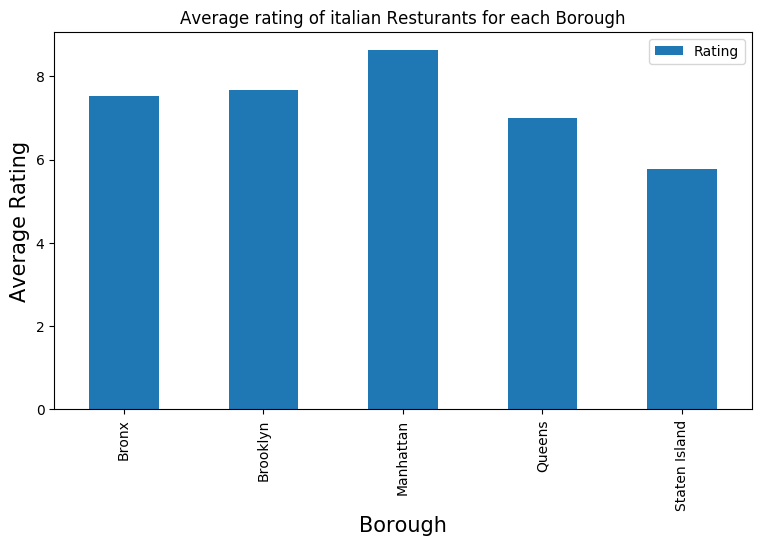

In [35]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of italian Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
italian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We will consider all the neighborhoods with average rating greater or equal 9.0 to visualize on map

In [36]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=9.0]

In [37]:
ny_neighborhood_stats

,Neighborhood,Average Rating
12,Boerum Hill,9.200000
18,Central Harlem,9.000000
34,Downtown,9.200000
50,Fort Greene,9.000000
63,Greenwich Village,9.233333
89,Noho,9.000000
91,North Side,9.000000
134,West Village,9.150000


We will join this dataset to original new york data to get lonitude and latitude

In [38]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [39]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [51]:
ny_neighborhood_stats.sort_values('Average Rating', ascending=True)

,Borough,Neighborhood,Latitude,Longitude,Average Rating,Label
1,Manhattan,Central Harlem,40.815976,-73.943211,9.000000,"Central Harlem, Manhattan(9.0)"
3,Brooklyn,Fort Greene,40.688527,-73.972906,9.000000,"Fort Greene, Brooklyn(9.0)"
5,Manhattan,Noho,40.723259,-73.988434,9.000000,"Noho, Manhattan(9.0)"
6,Brooklyn,North Side,40.714823,-73.958809,9.000000,"North Side, Brooklyn(9.0)"
7,Manhattan,West Village,40.734434,-74.006180,9.150000,"West Village, Manhattan(9.149999999999999)"
0,Brooklyn,Boerum Hill,40.685683,-73.983748,9.200000,"Boerum Hill, Brooklyn(9.2)"
2,Brooklyn,Downtown,40.690844,-73.983463,9.200000,"Downtown, Brooklyn(9.2)"
4,Manhattan,Greenwich Village,40.726933,-73.999914,9.233333,"Greenwich Village, Manhattan(9.233333333333334)"


Now we will show this data on a map

In [41]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [42]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )


Lets add a new field to dataframe for labeling purpose

In [43]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [44]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

Now that we have visualized the Neighborhoods.
<br>Lets Visualize Boroughs based on average Rating

In [54]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = r'Borough Boundaries.geojson'

ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)

# display map
# as this is huge map data , we will save it to a file
ny_map.save('rating.html')

/Users/joprudencio/.virtualenvs/coursera/lib/python3.7/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


**The saved image can be downloaded at** : 
https://github.com/joaoandre/Coursera_Capstone/blob/master/rating.html

### Conclusion 
- Greenwich Village(Manhattan), Boerum Hill(Brooklyn), Downtown(Brooklyn) are some of the best neighborhoods for italian cuisine. 
- Staten Island	ranks last in average rating of italian Resturants.
- Brooklyn is the best place to stay if you prefer italian Cuisine.

### Limitations 
- The ranking is purely on basis of rating of resturants
- The accuracy of data depends purely depends on the data provided by FourSquare